<a href="https://colab.research.google.com/github/PARZIWALL/EDA-and-Clustering-/blob/main/Gagan_Sharma_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: Customers.csv:
# https://drive.google.com/file/d/1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE/view?usp=sharing
# Products.csv :
# https://drive.google.com/file/d/1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0/view?usp=sharing
# Transactions.csv :
# https://drive.google.com/file/d/1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF/view?usp=sharing
# downLOad these datasets

!wget https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE -O Customers.csv
!wget https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0 -O Products.csv
!wget https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF -O Transactions.csv


--2025-01-23 16:32:43--  https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE
Resolving drive.google.com (drive.google.com)... 108.177.98.102, 108.177.98.139, 108.177.98.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.98.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE [following]
--2025-01-23 16:32:43--  https://drive.usercontent.google.com/download?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.188.132, 2607:f8b0:400e:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.188.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8542 (8.3K) [application/octet-stream]
Saving to: ‘Customers.csv’

Customers.csv       100%[===================>]   8.34K  --.-KB/s    in 0s      

2025-01-23 16:32:46 (50.9 MB/s) -

Applying KMeans clustering...
KMeans - DB Index: 0.8950365287786601, Silhouette Score: 0.355876777278508


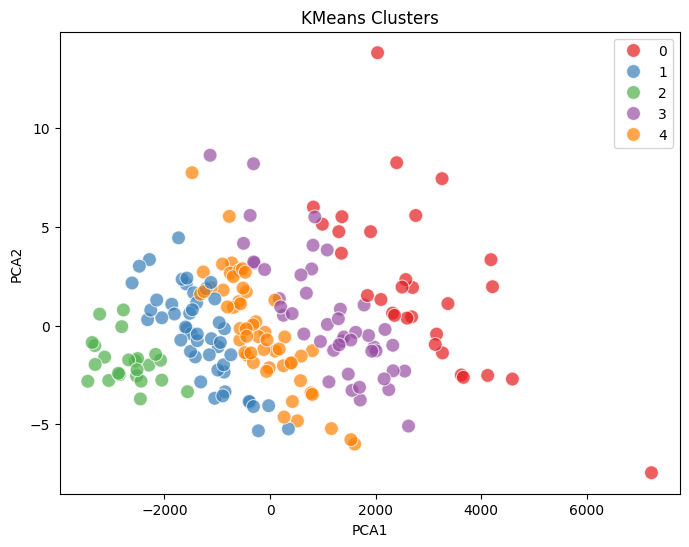

Applying DBSCAN clustering...
DBSCAN - DB Index: 1.0618493180873763, Silhouette Score: 0.39205754053661596


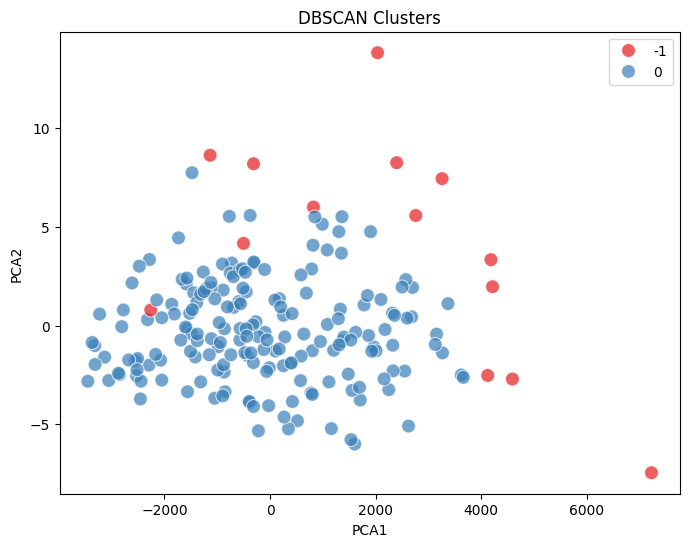

Applying Agglomerative clustering...
Agglomerative - DB Index: 0.9336173263844396, Silhouette Score: 0.33143847675783633


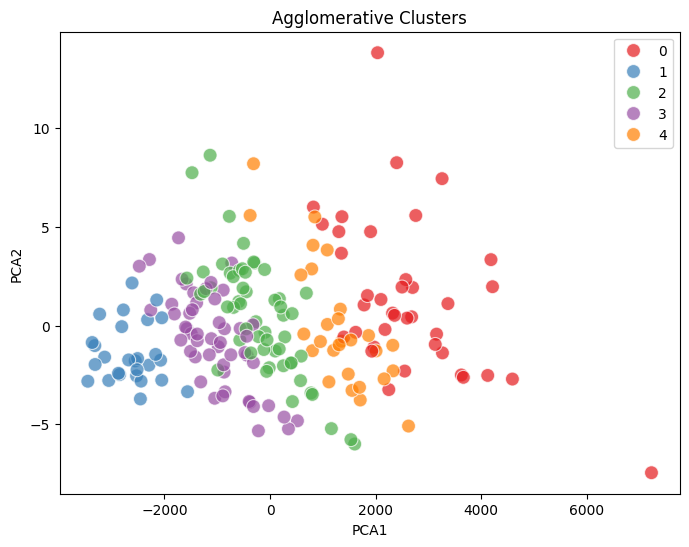

Applying GMM clustering...
GMM - DB Index: 1.210927648702476, Silhouette Score: 0.22362680714674318


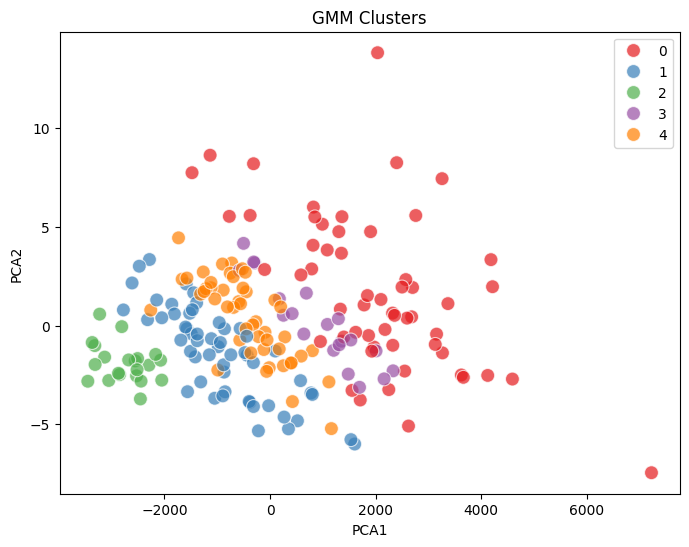


Best Algorithm: KMeans
DB Index: 0.8950365287786601, Silhouette Score: 0.355876777278508
Cluster distribution: 
Cluster
4    54
1    48
3    45
0    30
2    23
Name: count, dtype: int64


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data():
    """Load and preprocess the customer and transaction data."""
    customers = pd.read_csv('Customers.csv')
    transactions = pd.read_csv('Transactions.csv')

    # Convert dates to datetime
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
    transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

    # Aggregate transaction data by customer
    customer_stats = transactions.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Number of transactions
        'TotalValue': 'sum',       # Total spend
        'Quantity': 'sum'          # Total quantity purchased
    }).reset_index()

    # Merge customer profile with transaction stats
    merged_data = customers.merge(customer_stats, on='CustomerID', how='left')

    # Handle missing values
    merged_data = merged_data.fillna(0)

    return merged_data

def apply_clustering(algorithm, data, n_clusters=5):
    """Apply different clustering algorithms and return their metrics and results."""
    features = data[['TransactionID', 'TotalValue', 'Quantity']]

    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    if algorithm == 'KMeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = model.fit_predict(scaled_features)

    elif algorithm == 'DBSCAN':
        model = DBSCAN()
        clusters = model.fit_predict(scaled_features)

    elif algorithm == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
        clusters = model.fit_predict(scaled_features)

    elif algorithm == 'GMM':
        model = GaussianMixture(n_components=n_clusters, random_state=42)
        clusters = model.fit_predict(scaled_features)

    # Calculate metrics
    db_index = davies_bouldin_score(scaled_features, clusters)
    silhouette_avg = silhouette_score(scaled_features, clusters)

    # Return results
    return clusters, db_index, silhouette_avg

def visualize_clusters(clusters, data, algorithm):
    """Visualize clusters using PCA for 2D representation."""
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(data[['TransactionID', 'TotalValue', 'Quantity']])
    data['PCA1'] = pca_components[:, 0]
    data['PCA2'] = pca_components[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x='PCA1', y='PCA2', hue=clusters, palette='Set1', s=100, alpha=0.7)
    plt.title(f'{algorithm} Clusters')
    plt.show()

def main():
    # Load and preprocess data
    data = load_and_preprocess_data()

    # Define algorithms to apply
    algorithms = ['KMeans', 'DBSCAN', 'Agglomerative', 'GMM']
    n_clusters = 5  # You can adjust this as needed

    best_algorithm = None
    best_db_index = np.inf
    best_silhouette_score = -1
    final_clusters = None

    # Apply each algorithm and compare results
    for algo in algorithms:
        print(f"Applying {algo} clustering...")

        clusters, db_index, silhouette_avg = apply_clustering(algo, data, n_clusters)

        print(f"{algo} - DB Index: {db_index}, Silhouette Score: {silhouette_avg}")

        # Store the best algorithm based on DB Index and Silhouette Score
        if db_index < best_db_index and silhouette_avg > best_silhouette_score:
            best_algorithm = algo
            best_db_index = db_index
            best_silhouette_score = silhouette_avg
            final_clusters = clusters

        # Visualize the clusters for each algorithm
        visualize_clusters(clusters, data, algo)

    # Final result with the best algorithm
    print(f"\nBest Algorithm: {best_algorithm}")
    print(f"DB Index: {best_db_index}, Silhouette Score: {best_silhouette_score}")

    # Assign final clusters to the data
    data['Cluster'] = final_clusters
    print(f"Cluster distribution: \n{data['Cluster'].value_counts()}")

if __name__ == "__main__":
    main()
